In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [50]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, roc_auc_score,precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.ensemble import RandomForestClassifier

## Load Datasets

In [51]:
engagement=pd.read_csv('takehome_user_engagement.csv')
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [52]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [53]:
engagement['visited'].unique()

array([1])

In [54]:
users=pd.read_csv('takehome_users.csv',engine='python')
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [55]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


## Find Adopted Users

In [56]:
engagement['time_stamp']=engagement['time_stamp'].apply(lambda d: datetime.strptime(d, '%Y-%m-%d %H:%M:%S'))

In [57]:
engagement['date']=engagement['time_stamp'].apply(lambda d: datetime.date(d))

In [58]:
pivot = pd.pivot_table(engagement, values='visited', index='date',columns='user_id', aggfunc=np.sum)

In [59]:
#check if dates are continuous
all_date = pd.Series(data=pd.date_range(start=pivot.index.min(), end=pivot.index.max(), freq='D'))
mask = all_date.isin(pivot.index.values)
print(all_date[~mask])

735   2014-06-05
dtype: datetime64[ns]


In [60]:
#reindex to fillin missing dates
pivot= pivot.reindex(pd.date_range(pivot.index[0], pivot.index[-1], freq='D')).fillna(0)

In [61]:
pivot_rolling=pivot.rolling(7).sum()

In [62]:
adopted_users= list(pivot_rolling.columns[pivot_rolling.apply(lambda col: np.nanmax(col),axis=0)>=3].values)

In [63]:
mask= pivot_rolling.columns.isin(adopted_users)

In [64]:
not_adopted_users=list(pivot_rolling.columns[~mask])

In [65]:
#add adopted users as user type in to the users table
users['user_type']=[1 if x in adopted_users else 0 for x in users['object_id']]

## Exploratory Analysis and Visualization

Text(0.5, 1.0, 'Distribution of Adopted Users and Non Adopted Users')

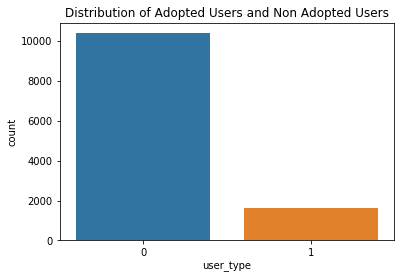

In [66]:
sns.countplot(x="user_type", data=users)
plt.title('Distribution of Adopted Users and Non Adopted Users')

The dataset is imbalanced. To ensure the accuracy of the classification model, we need to use the SMOTE algorithm to oversample the minority class.

In [67]:
users.drop(['email','name'],axis=1)
users.creation_time = pd.to_datetime(users.creation_time)
users.last_session_creation_time = pd.to_datetime(users.last_session_creation_time, unit='s')
users['time_delta_session_signup'] = users.last_session_creation_time-users.creation_time
users['time_delta_session_signup']=users['time_delta_session_signup'].apply(lambda d: d.days)
users=users.drop(['email','name','creation_time','last_session_creation_time'],axis=1)

In [68]:
#only 8823 users ever created a session,fill in thoses without a session by a very large number 5000
values = {'time_delta_session_signup': 5000}
users.fillna(value=values,inplace=True)

In [69]:
#users who are not invited by other users, fill in the column by their own id
users['invited_by_user_id'] = users.apply(
    lambda row: row['object_id'] if np.isnan(row['invited_by_user_id']) else row['invited_by_user_id'],
    axis=1)

In [70]:
users=pd.get_dummies(users,drop_first=True)

In [71]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
object_id                             12000 non-null int64
opted_in_to_mailing_list              12000 non-null int64
enabled_for_marketing_drip            12000 non-null int64
org_id                                12000 non-null int64
invited_by_user_id                    12000 non-null float64
user_type                             12000 non-null int64
time_delta_session_signup             12000 non-null float64
creation_source_ORG_INVITE            12000 non-null uint8
creation_source_PERSONAL_PROJECTS     12000 non-null uint8
creation_source_SIGNUP                12000 non-null uint8
creation_source_SIGNUP_GOOGLE_AUTH    12000 non-null uint8
dtypes: float64(2), int64(5), uint8(4)
memory usage: 703.2 KB


## Prediction Models and Evaluations

In [72]:
X=users.drop('user_type',axis=1)
y=users.user_type

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

In [74]:
smt = SMOTE()
X_train_smt, y_train_smt = smt.fit_sample(X_train, y_train)

In [75]:
np.bincount(y_train_smt)

array([7279, 7279])

In [76]:
clf = RandomForestClassifier()

In [77]:
clf.fit(X_train_smt,y_train_smt)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [78]:
clf.feature_importances_

array([0.02779888, 0.01882812, 0.00882041, 0.03975674, 0.02726406,
       0.78685595, 0.02025504, 0.05500451, 0.00866464, 0.00675164])

In [79]:
y_pred=clf.predict(X_test)

In [80]:
y_pred_prob=clf.predict_proba(X_test)[:,1]

In [81]:
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
auc=roc_auc_score(y_test,y_pred_prob)
print(auc)

0.9666666666666667
0.9877176236586304


In [82]:
confusion_matrix(y_test, y_pred)

array([[3041,   78],
       [  42,  439]])

In [83]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

In [84]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

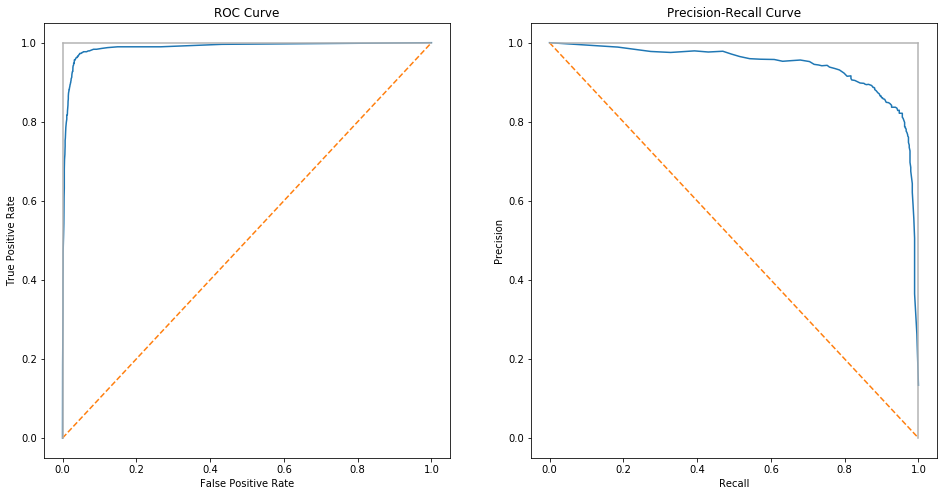

In [85]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.title("ROC Curve")
plt.plot(fpr,tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.subplot(1,2,2)
plt.title("Precision-Recall Curve")
plt.plot(recall,precision)
plt.plot([1, 0], ls="--")
plt.plot([1, 1], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

Feature ranking:
1. feature 5 (0.786856)
2. feature 7 (0.055005)
3. feature 3 (0.039757)
4. feature 0 (0.027799)
5. feature 4 (0.027264)
6. feature 6 (0.020255)
7. feature 1 (0.018828)
8. feature 2 (0.008820)
9. feature 8 (0.008665)
10. feature 9 (0.006752)


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

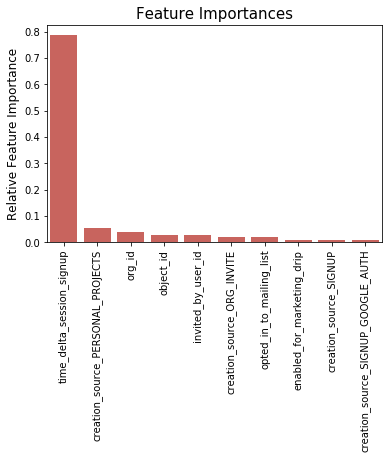

In [87]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
sns.barplot(x=X_train.columns[indices], y=importances[indices], color=sns.xkcd_rgb["pale red"])
plt.title('Feature Importances', fontsize=15)
plt.ylabel('Relative Feature Importance', fontsize=12)
plt.xticks(fontsize=10, rotation=90)

In [47]:
clf2 = RandomForestClassifier(class_weight='balanced')
clf2.fit(X_train,y_train)
y_pred_2=clf2.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_2)
print(accuracy)
y_pred_prob_2=clf2.predict_proba(X_test)[:,1]
auc=roc_auc_score(y_test,y_pred_prob_2)
print(auc)

0.9705555555555555
0.9894793429580221


In [88]:
confusion_matrix(y_test,y_pred_2)

array([[3084,   35],
       [  71,  410]])

In [89]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_2)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob_2)

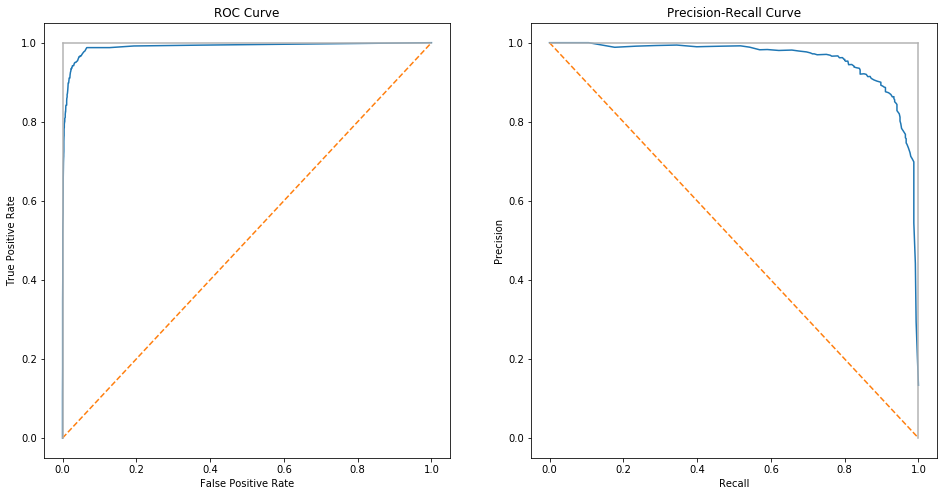

In [90]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.title("ROC Curve")
plt.plot(fpr,tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.subplot(1,2,2)
plt.title("Precision-Recall Curve")
plt.plot(recall,precision)
plt.plot([1, 0], ls="--")
plt.plot([1, 1], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

Feature ranking:
1. feature 5 (0.843715)
2. feature 3 (0.043462)
3. feature 0 (0.038716)
4. feature 4 (0.038453)
5. feature 7 (0.017174)
6. feature 9 (0.005348)
7. feature 1 (0.003433)
8. feature 8 (0.003430)
9. feature 6 (0.003177)
10. feature 2 (0.003093)


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

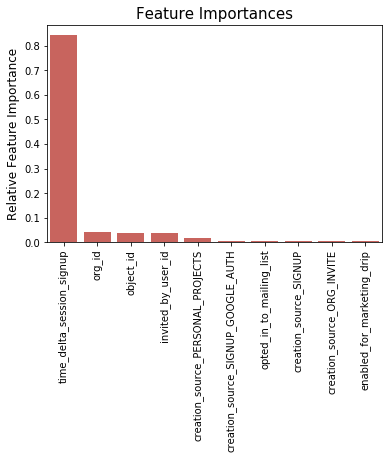

In [91]:
importances = clf2.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf2.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
sns.barplot(x=X_train.columns[indices], y=importances[indices], color=sns.xkcd_rgb["pale red"])
plt.title('Feature Importances', fontsize=15)
plt.ylabel('Relative Feature Importance', fontsize=12)
plt.xticks(fontsize=10, rotation=90)

In [44]:
clf3 = RandomForestClassifier(class_weight='balanced_subsample')
clf3.fit(X_train,y_train)
y_pred_3=clf3.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_3)
print(accuracy)
y_pred_prob_3=clf3.predict_proba(X_test)[:,1]
auc=roc_auc_score(y_test,y_pred_prob_3)
print(auc)

0.9708333333333333
0.988641809738315


In [92]:
confusion_matrix(y_test,y_pred_3)

array([[3082,   37],
       [  68,  413]])

In [46]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_3)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob_3)

array([0.03750018, 0.00361317, 0.00258635, 0.0435053 , 0.0380835 ,
       0.84053577, 0.00371875, 0.02219392, 0.00343079, 0.00483228])

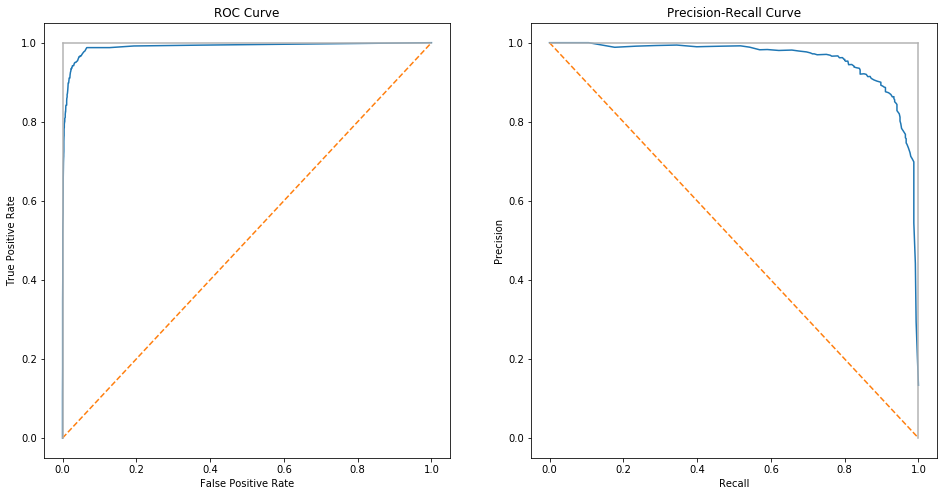

In [93]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.title("ROC Curve")
plt.plot(fpr,tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.subplot(1,2,2)
plt.title("Precision-Recall Curve")
plt.plot(recall,precision)
plt.plot([1, 0], ls="--")
plt.plot([1, 1], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

Feature ranking:
1. feature 5 (0.840536)
2. feature 3 (0.043505)
3. feature 4 (0.038083)
4. feature 0 (0.037500)
5. feature 7 (0.022194)
6. feature 9 (0.004832)
7. feature 6 (0.003719)
8. feature 1 (0.003613)
9. feature 8 (0.003431)
10. feature 2 (0.002586)


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

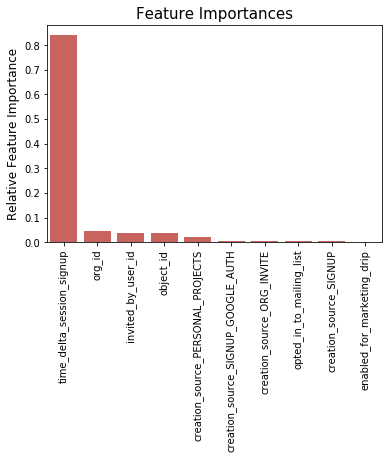

In [94]:
importances = clf3.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf3.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
sns.barplot(x=X_train.columns[indices], y=importances[indices], color=sns.xkcd_rgb["pale red"])
plt.title('Feature Importances', fontsize=15)
plt.ylabel('Relative Feature Importance', fontsize=12)
plt.xticks(fontsize=10, rotation=90)

Observations and Conclusions:

1. The time between signup and the last session is the most important feature to predict an adopted user. It could be the longer the user use the product, the more likely he is adopted, or it could be the adopted users end up using it longer.
2. The organization the user belongs to is an important feature to predict users adoption. It would be helpful if the team works to understand better of the needs of different organizations, and either develop features to match their need, or market more too organizations whose need could be meet by the product.
3. The invited by user id is an important feature. The marketing team could approach the influential users and ask them to help publicize the product.